## Homicide Dataset exploration,prediction and suggestions

**The goal is to look at the homicide data set from 2007 -2017 and make suggestions to the Federal government about allocation of resources across 50 cities in the United States.
The task will involve exploring the data and running time series forecasting to understand and predict the homicide situation in the cities identified.
Finally, suggestions based on the insights obtained will be provided to the Federal government.

### Data Wrangling

In [2]:
#Installing necessary libraries and datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA

#homicide data 
homicide = pd.read_csv("Homicides.csv")
#region mapping to state
usa_region = pd.read_csv("C:/Users/kirti/Downloads/MSBA/Data Analytics Programming/Group_Assignment/USA_region.csv")
#US census data for population stats
usa_census = pd.read_csv("C:/Users/kirti/Downloads/MSBA/Data Analytics Programming/Group_Assignment/USA_census.csv")
#Census data at city level
usa_city = pd.read_csv("C:/Users/kirti/Downloads/MSBA/Data Analytics Programming/Group_Assignment/USA_city.csv")
#Crime rate data at state level
crime_rates = pd.read_csv("C:/Users/kirti/Downloads/MSBA/Data Analytics Programming/Group_Assignment/crime_rates_statewise.csv")

In [3]:
#Data Cleaning
#Replacing victim last name NA as blank and subsetting entries with no location detected
homicide.isnull().sum()
homicide['victim_last'] = homicide['victim_last'].fillna('')
homicide[homicide['victim_last'].isnull()]
no_loc_entries = homicide[homicide['lat'].isnull()]

In [4]:
#Merging Tables to generate ADS
crime_rates =crime_rates.loc[:, 'state_name':'2007']
usa_city['city'] = usa_city['city'].apply(lambda x : ' '.join(x.split(" ")[:-1]))
homicide_all = pd.merge(homicide,usa_region,on = 'state', how ='inner')
homicide_all = pd.merge(homicide_all,usa_city,on = 'city', how ='inner')
homicide_all = pd.merge(homicide_all,usa_census,left_on = 'st_name',right_on='Geographic Area',how ='inner')
homicide_all = homicide_all.drop(columns='state_y')
homicide_all = homicide_all.rename(index=str, columns={"state_x": "state" ,"st_name":'state_name'})

In [5]:
#Replacing wrong date entries and changing date format to dateTime
#datetime.datetime.strptime("21/12/2008", "%d/%m/%Y").strftime("%Y-%m-%d")
homicide_all['reported_date'] = homicide_all['reported_date'].replace(201511018,20151118)
homicide_all['reported_date'] = homicide_all['reported_date'].replace(201511105,20151105)
homicide_all['reported_date'] = homicide_all['reported_date'].apply(lambda l : datetime.strptime(str(l),"%Y%m%d").strftime("%Y-%m-%d"))
homicide_all['reported_date'] = homicide_all['reported_date'].astype('datetime64[ns]')

### Exploratory Data Analysis

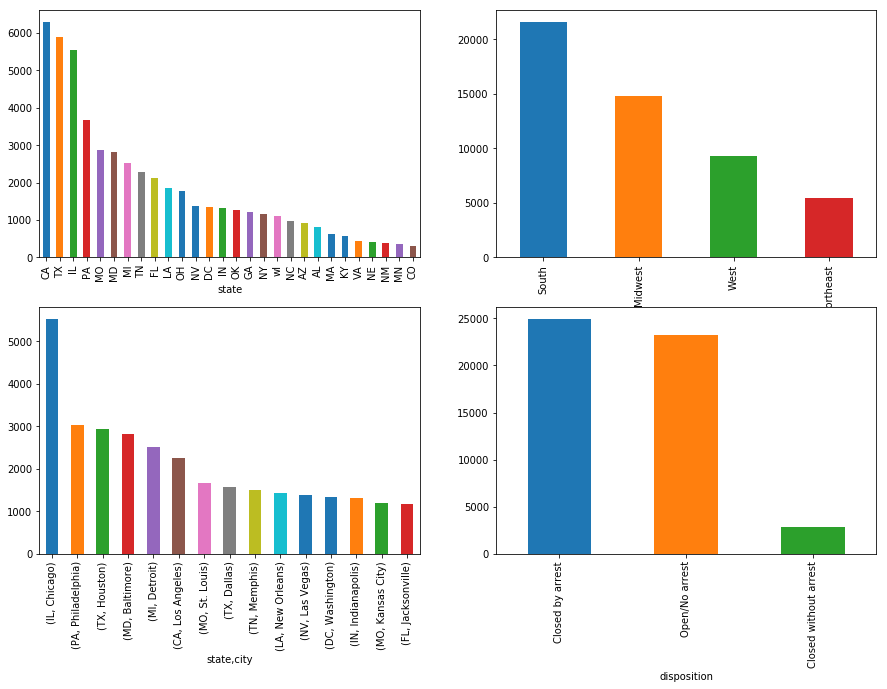

In [6]:
#Identifying tops states,regions,cities and disposition rate with the highest homicide numbers
fig,([ax1, ax2],[ax3,ax4]) = plt.subplots(nrows=2,
                                        ncols=2,
                                        sharex=False,
                                        sharey=False,
                                        figsize=(15,10))
top10_states = homicide.groupby("state").count()['uid'].sort_values(ascending=False).iloc[:10]
homicide.groupby("state").count()['uid'].sort_values(ascending=False).plot.bar(ax=ax1)
homicide = pd.merge(homicide,usa_region, on = 'state', how='inner')
homicide.groupby("region").count()['uid'].sort_values(ascending=False).plot.bar(ax=ax2)
homicide.groupby(["state","city"])['uid'].agg('count').sort_values(ascending=False).groupby("state").head(3).iloc[:15].plot.bar(ax=ax3)
homicide.groupby("disposition").count()['uid'].sort_values(ascending=False).plot.bar(ax=ax4)

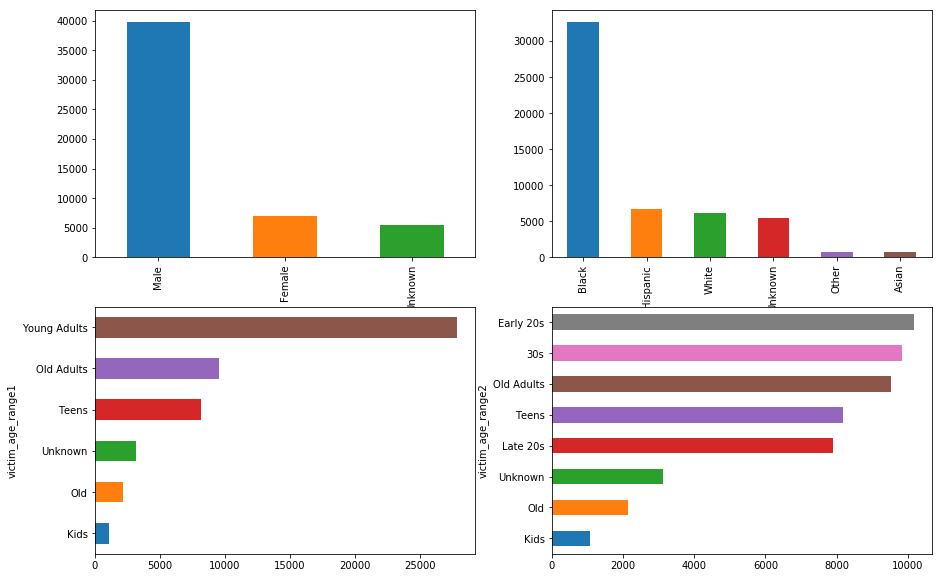

In [37]:
#Looking at the demographic variables
fig,([ax1, ax2],[ax3,ax4]) = plt.subplots(nrows=2,
                                        ncols=2,
                                        sharex=False,
                                        sharey=False,
                                        figsize=(15,10))
homicide.groupby('victim_sex')['uid'].count().sort_values(ascending=False).plot.bar(ax=ax1)
homicide.groupby('victim_race')['uid'].count().sort_values(ascending=False).plot.bar(ax=ax2)

#Grouping ages
homicide['victim_age'] = homicide['victim_age'].replace('Unknown', 999)
homicide.groupby('victim_age')['uid'].count().sort_values(ascending=False)
homicide['victim_age']= homicide['victim_age'].astype(int)

homicide['victim_age_range1'] = pd.cut(homicide['victim_age'], [0, 12, 20, 40, 60,102,1000],labels = ['Kids', 'Teens', 'Young Adults','Old Adults','Old','Unknown'])
homicide.groupby('victim_age_range1')['uid'].count().sort_values(ascending = True).plot.barh(ax=ax3)
homicide['victim_age_range2'] = pd.cut(homicide['victim_age'], [0, 12, 20,25,30,40, 60,102,1000],labels = ['Kids', 'Teens', 'Early 20s','Late 20s','30s','Old Adults','Old','Unknown'])
homicide.groupby('victim_age_range2')['uid'].count().sort_values(ascending = True).plot.barh(ax=ax4)
homicide_new = homicide

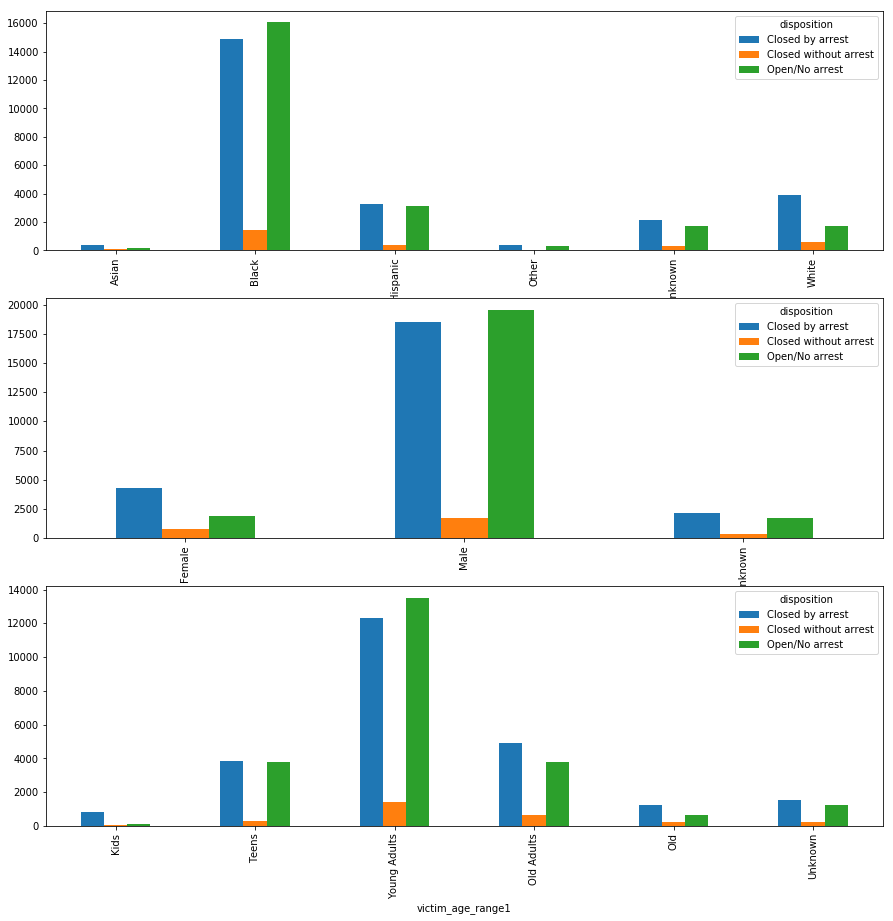

In [8]:
#African Americans not only are the most frequent victims of homicide, they have the worst ratio of cases being solved
#Similarly for males and Young males
fig,(ax1, ax2,ax3) = plt.subplots(nrows=3,
                                        ncols=1,
                                        sharex=False,
                                        sharey=False,
                                        figsize=(15,15))


homicide.groupby(['victim_race','disposition'])['uid'].count().sort_values(ascending=False).unstack().plot.bar(ax =ax1)
homicide.groupby(['victim_sex','disposition'])['uid'].count().sort_values(ascending=False).unstack().plot.bar(ax =ax2)
homicide.groupby(['victim_age_range1','disposition'])['uid'].count().sort_values(ascending=False).unstack().plot.bar(ax =ax3)

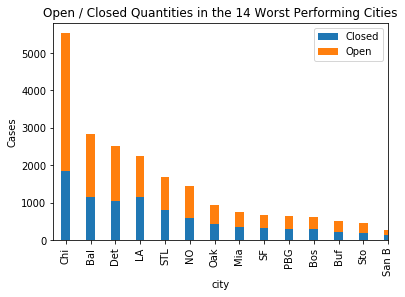

In [9]:
#This code snippet is to identify the worst cities with respect to the number of closed cases.
#Closure rate depicts the number of cases closed successfully 


def is_closed(s):
    """Assigns a value to whether a case is or is not closed"""
    if s == 'Closed without arrest' or s == 'Closed by arrest':
        return 1
    else:
        return 0
    
homicide['closed'] = homicide['disposition'].map(is_closed)

city_rate = homicide.groupby(['city'])['closed'].agg('mean').sort_values()
city_rate[:10].plot.bar()

bottom_cities = city_rate[:14]
bottom_cities

def bottom_14(s):
    """Checks if a homicide occurred in one of the 14 worst performing cities"""
    return s in bottom_cities

worst_performers = homicide[homicide['city'].map(bottom_14)]
worst_performers_open = worst_performers[worst_performers['closed'] == 0]
worst_performers_closed = worst_performers[worst_performers['closed'] != 0]

cities = ['Chicago', 'Baltimore', 'Detroit', 'Los Angeles', 'St. Louis', 'New Orleans', 'Oakland', 'Miami', 'San Francisco', 'Pittsburgh', 'Boston', 'Buffalo', 'Stockton', 'San Bernardino']

open_values = worst_performers_open['city'].value_counts().reindex(cities)
closed_values = worst_performers_closed['city'].value_counts().reindex(cities)

N = 14
Open = open_values
Closed = closed_values
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, Closed, width)
p2 = plt.bar(ind, Open, width,
             bottom= Closed)

plt.ylabel('Cases')
plt.xticks(ind, ('Chi', 'Bal', 'Det', 'LA', 'STL', 'NO', 'Oak', 'Mia', 'SF', 'PBG', 'Bos', 'Buf', 'Sto', 'San B'))
plt.title('Open / Closed Quantities in the 14 Worst Performing Cities')
plt.legend((p1[0], p2[0]), ('Closed', 'Open'))

plt.show()


In [14]:
#Calculating State homicide % rate
homicide = homicide_all

homicide['reported_month'] = homicide['reported_date'].apply(lambda x : x.month)
homicide['reported_year'] = homicide['reported_date'].apply(lambda x : x.year)
homicide['reported_day'] = homicide['reported_date'].apply(lambda x : x.day)

state_census = usa_census.iloc[5:]
state_pop = pd.DataFrame({'st_bodies' : homicide.groupby(['state_name','reported_year'])['uid'].count()}).reset_index()

def func1(st_name,year) :
    value = state_census[state_census['Geographic Area'] == st_name][str(year)]
    return int(value)

state_pop['population'] = state_pop.apply(lambda x: func1(x.state_name, x.reported_year), axis=1)

state_pop['state_homicide%'] = (state_pop['st_bodies'] * 100)/state_pop['population']


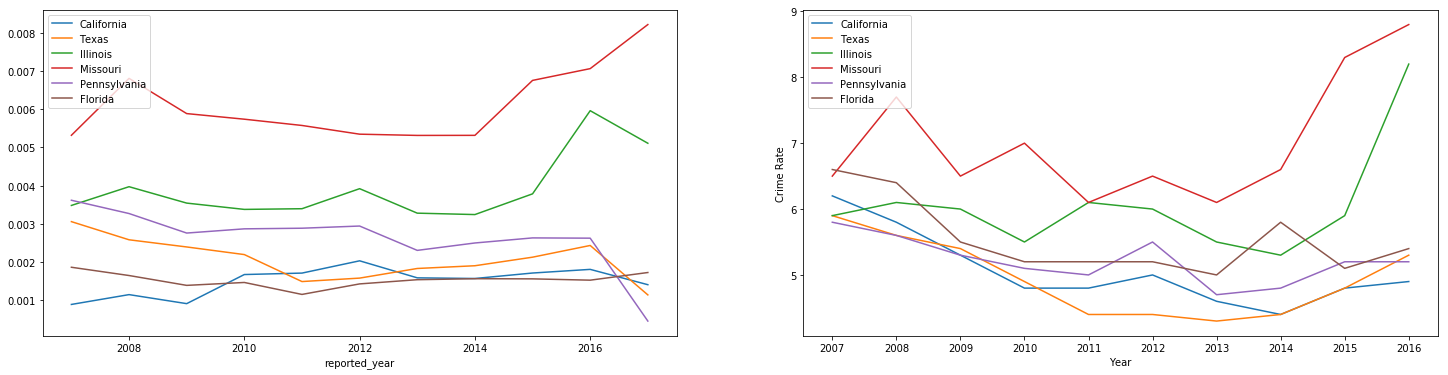

In [16]:
#Comparing state wise homicide % with the crime rates from FBI
#Missouri has the highest homicide rate and crime rate wrt FBI stats
#Top 6 states homicides(norm) behavior across years

fig,(ax1,ax2) = plt.subplots(nrows=1,
                                        ncols=2,
                                        sharex=False,
                                        sharey=False,
                                        figsize=(25,6))

plt.xlabel('Year')
plt.ylabel('Homicide%')

#blue
state_pop[state_pop['state_name']=='California'].groupby('reported_year')['state_homicide%'].last().sort_index(ascending =True).plot.line(ax=ax1)
#yellow
state_pop[state_pop['state_name']=='Texas'].groupby('reported_year')['state_homicide%'].last().sort_index(ascending =True).plot.line(ax=ax1)
#green
state_pop[state_pop['state_name']=='Illinois'].groupby('reported_year')['state_homicide%'].last().sort_index(ascending =True).plot.line(ax=ax1)
#red
state_pop[state_pop['state_name']=='Missouri'].groupby('reported_year')['state_homicide%'].last().sort_index(ascending =True).plot.line(ax=ax1)
#purple
state_pop[state_pop['state_name']=='Pennsylvania'].groupby('reported_year')['state_homicide%'].last().sort_index(ascending =True).plot.line(ax=ax1)
#brown
state_pop[state_pop['state_name']=='Florida'].groupby('reported_year')['state_homicide%'].last().sort_index(ascending =True).plot.line(ax=ax1)
ax1.legend(['California', 'Texas', 'Illinois', 'Missouri','Pennsylvania','Florida'], loc='upper left')
plt.xlabel('Year')
plt.ylabel('Crime Rate')
#crime rate
#blue
ax2.plot(crime_rates[crime_rates['state_name']=='California'].transpose().iloc[1:][25].sort_index(ascending=True))
#yellow
ax2.plot(crime_rates[crime_rates['state_name']=='Texas'].transpose().iloc[1:][23].sort_index(ascending=True))
#green
ax2.plot(crime_rates[crime_rates['state_name']=='Illinois'].transpose().iloc[1:][3].sort_index(ascending=True))
#red
ax2.plot(crime_rates[crime_rates['state_name']=='Missouri'].transpose().iloc[1:][1].sort_index(ascending=True))
#purple
ax2.plot(crime_rates[crime_rates['state_name']=='Pennsylvania'].transpose().iloc[1:][24].sort_index(ascending=True))
#brown
ax2.plot(crime_rates[crime_rates['state_name']=='Florida'].transpose().iloc[1:][22].sort_index(ascending=True))
ax2.legend(['California', 'Texas', 'Illinois', 'Missouri','Pennsylvania','Florida'], loc='upper left')
#ax2.xlabel('Year')
#ax2.ylabel('')

In [18]:
#Calculating homicide % rate wrt population in every year

year_pop = pd.DataFrame({'bodies' : homicide.groupby('reported_year')['uid'].count()}).reset_index()
usa_pop = pd.DataFrame({'population' : usa_census.iloc[0]}).reset_index()
usa_pop = usa_pop[1:]
year_pop['reported_year'] = year_pop['reported_year'].apply(int)
usa_pop['index'] = usa_pop['index'].apply(int)

#Table with normalized number of deaths year wise for entire USA

py_full_norm = year_pop.merge(usa_pop,left_on='reported_year',right_on='index')
py_full_norm['homicide%'] = (py_full_norm['bodies']/py_full_norm['population'])*100


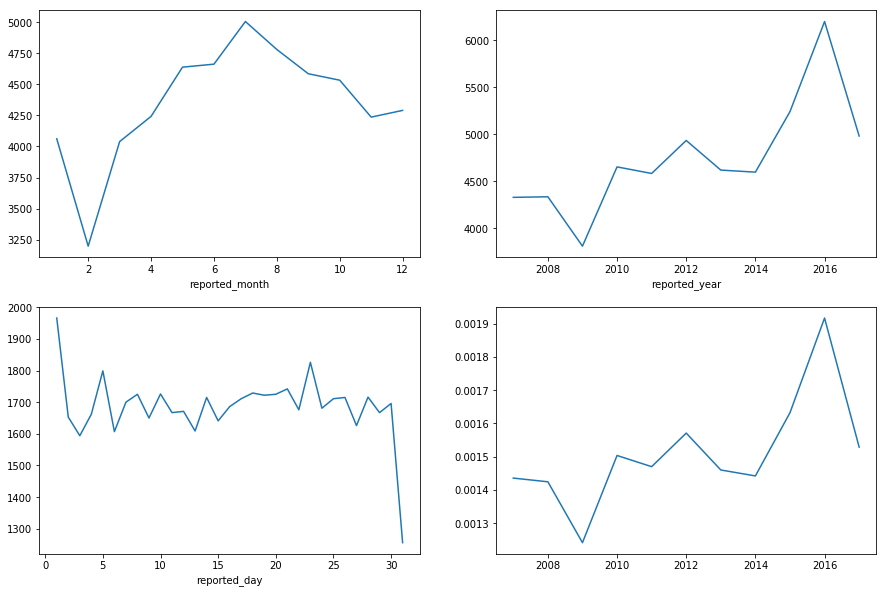

In [19]:
#Trends over Time

#Looking at year/month and day wise plots of the number of homicides from 2007 to 2017
fig,[[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2,
                                        ncols=2,
                                        sharex=False,
                                        sharey=False,
                                        figsize=(15,10))
homicide.groupby('reported_month')['uid'].count().sort_index(ascending = True).plot.line(ax=ax1)
homicide.groupby('reported_year')['uid'].count().sort_index(ascending = True).plot.line(ax=ax2)
homicide.groupby('reported_day')['uid'].count().sort_index(ascending = True).plot.line(ax=ax3)
ax4.plot(py_full_norm['index'],py_full_norm['homicide%'])

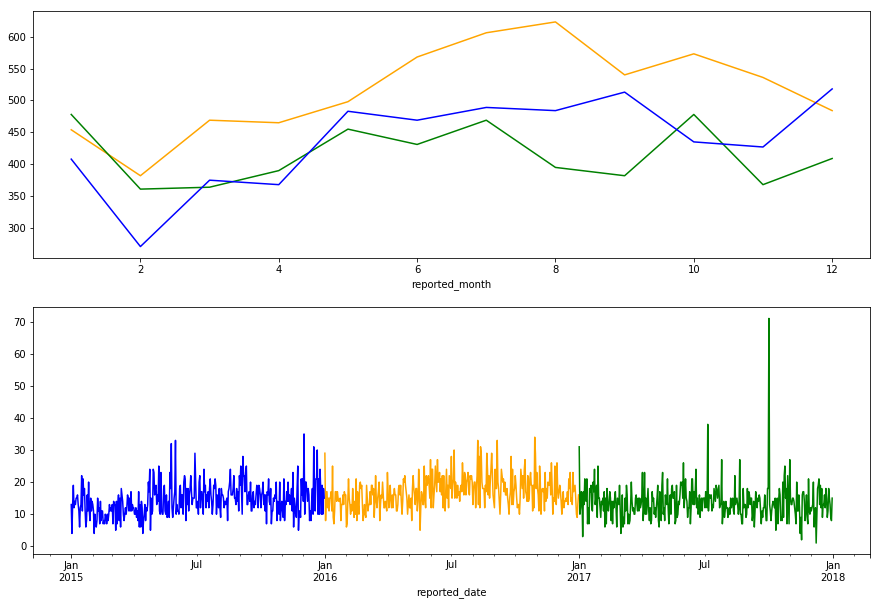

In [20]:
fig, (ax1,ax2) = plt.subplots(nrows=2,
                                ncols=1,
                                sharex=False,
                                sharey=False,
                                figsize=(15, 10))
homicide[homicide['reported_year'] == 2016].groupby(['reported_month'])['uid'].count().sort_index(ascending=True).plot.line(ax=ax1,color='orange')
homicide[homicide['reported_year'] == 2017].groupby(['reported_month'])['uid'].count().sort_index(ascending=True).plot.line(ax=ax1,color = 'green')
homicide[homicide['reported_year'] == 2015].groupby(['reported_month'])['uid'].count().sort_index(ascending=True).plot.line(ax=ax1,color = 'blue')


homicide[homicide['reported_year'] == 2016].groupby('reported_date')['uid'].count().sort_index(ascending=True).plot.line(ax=ax2,color ='orange')
homicide[homicide['reported_year'] == 2017].groupby('reported_date')['uid'].count().sort_index(ascending=True).plot.line(ax=ax2, color='green')
homicide[homicide['reported_year'] == 2015].groupby('reported_date')['uid'].count().sort_index(ascending=True).plot.line(ax=ax2,color ='blue')

In [27]:
#Plotting Google Maps
import pandas as pd
import gmplot as gmplot
lat = homicide['lat'].dropna()
lon = homicide['lon'].dropna()

In [30]:
#All cities
#All Cities
gmap = gmplot.GoogleMapPlotter(39.884990, -97.623507, 5)
gmap.heatmap(lat, lon, threshold = 15000, radius = 35)
gmap.draw("map.html")
gmap10 = gmplot.GoogleMapPlotter(39.884990, -97.623507, 5)
gmap10.scatter(lat, lon, size=100, marker=False, color = 'red')
gmap10.draw("map10.html") 

           city  city_homicide%
0   Los Angeles        0.000205
1       Chicago        0.000294
2       Houston        0.000362
3  Philadelphia        0.000513
4       Detroit        0.001161
5     Baltimore        0.001289
6   Kansas City        0.002578


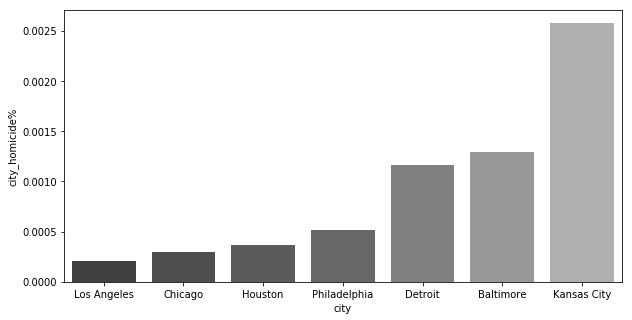

In [31]:
#Looking at city performance wrt state homicide rate
import seaborn as sns
city_pop = pd.DataFrame({'c_bodies' : homicide.groupby(['city','reported_year'])['uid'].count()}).reset_index()
city_census = homicide[homicide['reported_year'] > 2009].groupby(['city','reported_year']).sum()
city_combine = city_census.merge(city_pop, on =['city','reported_year'])


def func(year,ind):
    col_nm = str(year) + '_c'
    return city_combine.loc[ind,col_nm]

city_combine["population"] = city_combine.apply(axis =1, func = lambda x : func(x.reported_year,x.name))
city_combine['city_homicide%'] = city_combine.apply(axis =1, func = lambda x : (x.c_bodies*100.0)/x.population)

#fig, ax = pyplot.subplots(figsize=a4_dims)
fig, ax = plt.subplots(nrows=1,
                                ncols=1,
                                sharex=False,
                                sharey=False,
                                figsize=(10, 5))

tips = pd.DataFrame(city_combine[city_combine['city'].isin(['Chicago','Philadelphia','Houston','Baltimore','Detroit','Kansas City','Los Angeles'])].groupby('city')['city_homicide%'].sum().sort_values(ascending=True)).reset_index()
print tips
#plt.xlabel("Homicide %")
sns.barplot(ax=ax,x="city", y="city_homicide%", data=tips,palette="Greys_d")

**Looking at homicide number,rates and the worst closure rates we take Detroit,Chicago,LA nd Philadelphia as the worst performing cities wrt homicide
Lets look at these cities in detail
Code only for Baltimore....was repeated for the 4 mentioned above

In [33]:
list(homicide)

['uid',
 'reported_date',
 'victim_last',
 'victim_first',
 'victim_race',
 'victim_age',
 'victim_sex',
 'city',
 'state',
 'lat',
 'lon',
 'disposition',
 'state_name',
 'region',
 'division',
 '2010_c',
 '2011_c',
 '2012_c',
 '2013_c',
 '2014_c',
 '2015_c',
 '2016_c',
 '2017_c',
 'Geographic Area',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 'reported_month',
 'reported_year',
 'reported_day']

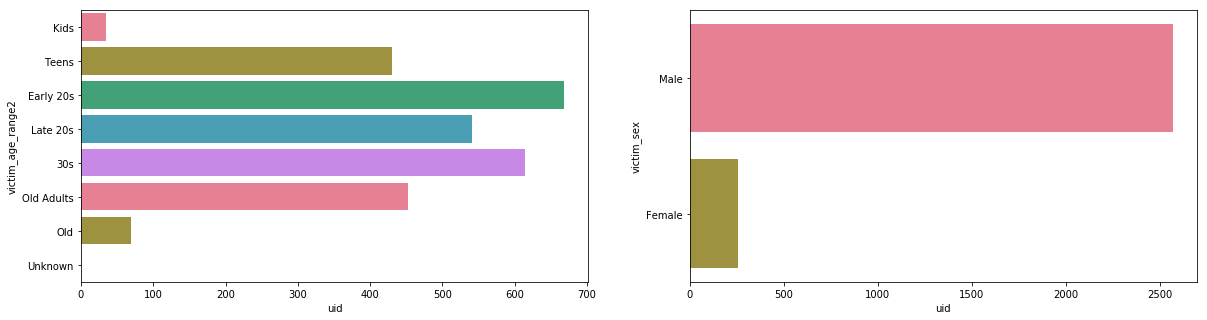

In [40]:
#Looking at the Age and Sex distribution amongst the Baltimore victims
fig,(ax1, ax2) = plt.subplots(nrows=1,
                                        ncols=2,
                                        sharex=False,
                                        sharey=False,
                                        figsize=(20,5))
tips = pd.DataFrame(homicide_new[homicide_new['city']=='Baltimore'].groupby('victim_age_range2')['uid'].count().sort_values(ascending = False)).reset_index()
#plt.xlabel("Homicide %")
sns.barplot(ax=ax1,x="uid", y="victim_age_range2", data=tips,palette=sns.color_palette("husl", 5))

tips = pd.DataFrame(homicide_new[homicide_new['city']=='Baltimore'].groupby('victim_sex')['uid'].count().sort_values(ascending = False)).reset_index()
#plt.xlabel("Homicide %")
sns.barplot(ax=ax2,x="uid", y="victim_sex", data=tips,palette=sns.color_palette("husl", 5))


Text(0.5,0,'Baltimore')

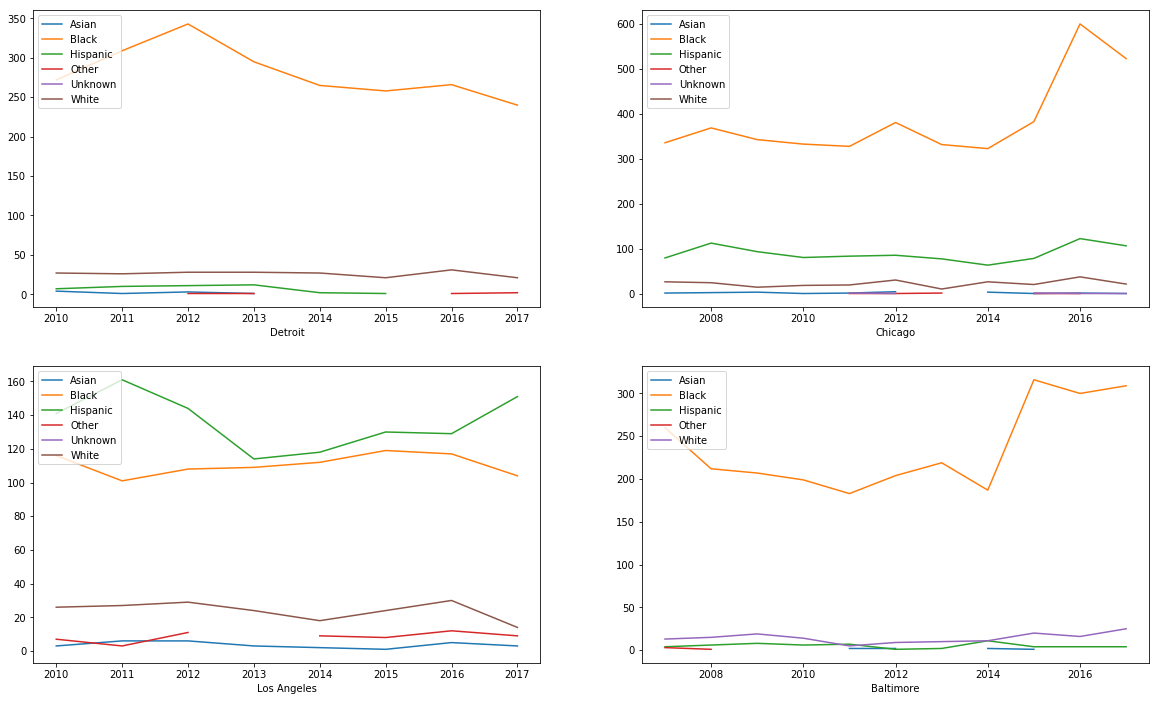

In [41]:
#Looking at Race distribution amongst the 4 cities 
fig,[[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2,
                                        ncols=2,
                                        sharex=False,
                                        sharey=False,
                                        figsize=(20,12))
#blue
homicide[homicide['city']=='Detroit'].groupby(['reported_year','victim_race'])['uid'].count().sort_index(ascending =True).unstack().plot.line(ax=ax1)
ax1.legend(loc='upper left')
ax1.set_xlabel('Detroit')
#yellow
homicide[homicide['city']=='Chicago'].groupby(['reported_year','victim_race'])['uid'].count().sort_index(ascending =True).unstack().plot.line(ax=ax2)
ax2.legend(loc='upper left')
ax2.set_xlabel('Chicago')
##green
homicide[homicide['city']=='Los Angeles'].groupby(['reported_year','victim_race'])['uid'].count().sort_index(ascending =True).unstack().plot.line(ax=ax3)
ax3.legend(loc='upper left')
ax3.set_xlabel('Los Angeles')
##red
homicide[homicide['city']=='Baltimore'].groupby(['reported_year','victim_race'])['uid'].count().sort_index(ascending =True).unstack().plot.line(ax=ax4)
ax4.legend(loc='upper left')
ax4.set_xlabel('Baltimore')


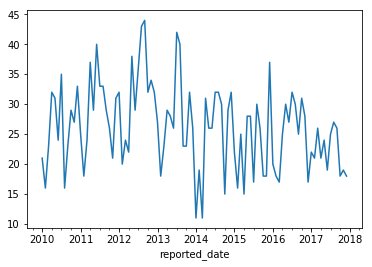

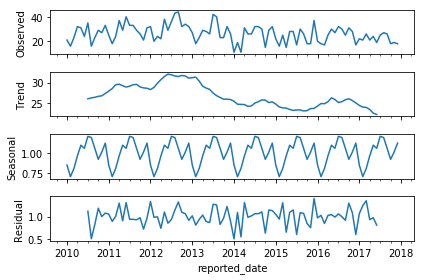

In [43]:
#Running ARIMA for the 4 cities identified to predict the homicide rate for the year 2018
#Code only for Detroit repeat for all cities

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import numpy as np

homicide_am_detroit = homicide[homicide['city']=='Detroit'].iloc[:,0:2]
homicide_am_chicago = homicide[homicide['city']=='Chicago'].iloc[:,0:2]
homicide_am_lasvegas = homicide[homicide['city']=='Las Vegas'].iloc[:,0:2]
homicide_am_baltimore = homicide[homicide['city']=='Baltimore'].iloc[:,0:2]

homicide_am = homicide.iloc[:,0:2]

homicide_am_detroit['reported_date'] = homicide_am_detroit['reported_date'].apply(lambda l : datetime.strptime(str(l),"%Y-%m-%d %H:%M:%S").strftime("%Y-%m"))


homicide_am_detroit['reported_date'] = homicide_am_detroit['reported_date'].astype('datetime64[ns]')

homicide_am_detroit.groupby('reported_date')['uid'].count().plot.line()
homicide_am_detroit=homicide_am_detroit.groupby('reported_date')['uid'].count()

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(homicide_am_detroit, model='multiplicative')
fig = result.plot()


In [44]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(homicide_am_detroit, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=638.408, BIC=651.177, Fit time=0.639 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=673.549, BIC=678.657, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=661.518, BIC=671.734, Fit time=0.232 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=639.940, BIC=650.156, Fit time=0.232 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=634.189, BIC=649.512, Fit time=0.937 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 12); AIC=637.850, BIC=650.620, Fit time=0.624 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=639.181, BIC=649.397, Fit time=0.575 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=634.2

[24.5029792  21.1381875  22.66395056 28.61637554 28.6562951  27.70360685
 32.00919342 30.27980994 28.19560827 24.89392238 27.37290863 28.6258737
 23.74996921 20.61211796 22.24216617 28.20699403 28.29433661 27.38182877
 31.66006172 29.96070026 27.90578277 24.64353063 27.09831954 28.33904728
 23.51571499 20.41138937 22.02368677 27.92422594 28.01001247 27.10656618
 31.33830769 29.65634522 27.62260999 24.39443857 26.82216671 28.04881121]


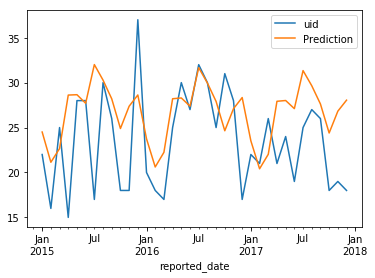

In [48]:
train = homicide_am_detroit.loc['2007-01':'2014-12']
test = homicide_am_detroit.loc['2015-01':]

stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=36)
print(future_forecast)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot.line()

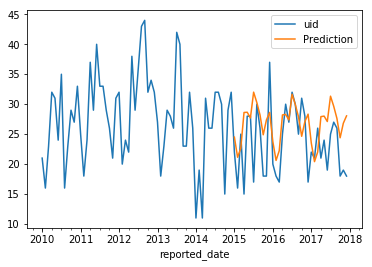

In [49]:
pd.concat([homicide_am_detroit,future_forecast],axis=1).plot.line()

[24.5029792  21.1381875  22.66395056 28.61637554 28.6562951  27.70360685
 32.00919342 30.27980994 28.19560827 24.89392238 27.37290863 28.6258737 ]


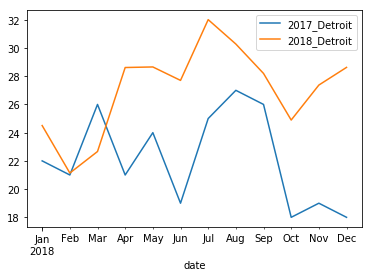

In [50]:

df= pd.DataFrame(data ={'date' : ['2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12']})
df['2017_Detroit'] = list(homicide[(homicide['reported_year'] == 2017) & (homicide['city'] == 'Detroit')].groupby('reported_month')['uid'].count().sort_index(ascending = True))
df['date'] = df['date'].astype('datetime64[ns]')
df = df.groupby('date')['2017_Detroit'].sum().sort_index(ascending =True)
test2 = df
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=12)
print(future_forecast)
future_forecast = pd.DataFrame(future_forecast,index = test2.index,columns=['2018_Detroit'])
pred2018 = pd.concat([test2,future_forecast],axis=1)
pred2018.plot.line()


In [51]:
#Detroit
lat_D = homicide[homicide['city'] == 'Detroit']['lat']
lon_D = homicide[homicide['city'] == 'Detroit']['lon']
gmap3 = gmplot.GoogleMapPlotter(42.336770, -83.075634, 11)
gmap3.heatmap(lat_D, lon_D)
gmap3.draw("map3.html") 
gmap13 = gmplot.GoogleMapPlotter(42.336770, -83.075634, 11)
gmap13.scatter(lat_D, lon_D, size=80, marker=False, color = 'red')
gmap13.draw("map13.html") 

**Ran the above codes for all the worst performing cities:LA,Baltimore,Detroit and Chicago and drew insights.In order to understand flow of the insight generation, look at the ppt attached.